# 02 - Bomb cyclone case study

In [1]:
# Import libraries and functions
from datetime import date

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
import cmocean as cmo

from qartod_testing.local_qc_test import load_gross_range_qartod_test_values, load_climatology_qartod_test_values
from ooi_data_explorations.common import m2m_request, m2m_collect

### Plot barometric pressure during bomb cyclone

In [2]:
# Set refdes and other data stream parameters
refdes = 'CP01CNSM-SBD11-06-METBKA000'
site, node, sensor = refdes.split('-',2)
method = 'recovered_host'
stream = 'metbk_hourly'
deploy = 14

In [3]:
# Import async data request dict from text file saved in notebook 01
file = f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    data = eval(f.read())

In [4]:
# Load data from thredds catalog via M2M API
cnsm_metbk = m2m_collect(data, tag=('.*deployment%04d.*metbk_a_dcl_instrument_recovered.*\.nc$' % deploy))

In [60]:
# Make barometric pressure and QARTOD results flag variables for 
# the same time period as the abstract figure
atm_pres = cnsm_metbk["barometric_pressure"].sel(time=slice('2021-10-21','2021-10-31'))
atm_pres_flag = cnsm_metbk["barometric_pressure_qartod_results"].sel(time=slice('2021-10-21','2021-10-31'))

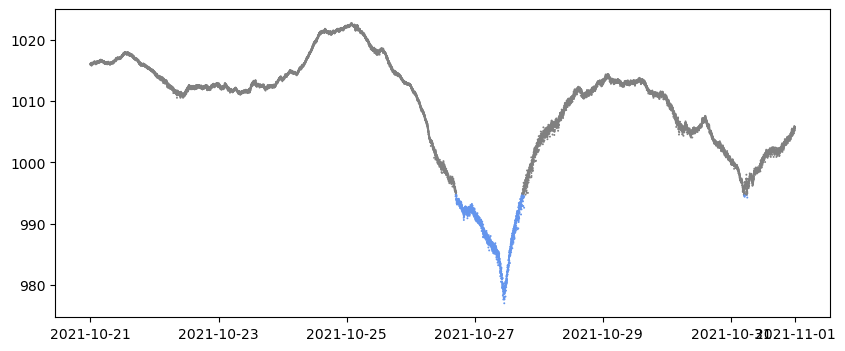

In [61]:
# Recreate figure from notebook 01
plt.figure(figsize=(10,4))
plt.scatter(atm_pres['time'], atm_pres.values, s=2, edgecolors='none',
            c=atm_pres_flag.values, cmap=ListedColormap(['gray', 'cornflowerblue']))

In [5]:
# Create shorter dataset during bomb cyclone
cnsm_cyclone = cnsm_metbk.sel(time=slice('2021-10-26T12:00:00','2021-10-28T00:00:00'))

Since we are using the metbk_hourly data stream, no burst averaging will be needed in this notebook.

In [6]:
# Create function to make plots with color from QARTOD flag result
def color_by_flag(ds, parameter, ax=None, fig=None):
    """ from dataset and parameter name string
    plot a timeseries of the named parameter and 
    color data points based on the corresponding QARTOD
    flag in the relevant _qartod_result parameter in
    the dataset.
    To-do: (maybe not if providing axes works better) 
    if parameter is a list-type, create subplots
    for each of the listed parameters
    Kylene M Cooley
    Version 6 Feb 2024
    
    Inputs:
    -------
    ds, xarray dataset
    parameter, string
    ax, optional matplotlib axes object
    fig, required if ax is provided
    
    Returns:
    --------
    fig, matplotlib figure object
    ax, matplotlib axes object
    """
    # Create data arrays to plot/color points
    da_plot = ds[parameter]
    da_color = ds[f"{parameter}_qartod_results"]
    
    # Create new axes object if none provided
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(8,3), layout="tight")
        # Plot data points in scatter plot
        ax.scatter(da_plot['time'].where(da_color==1), da_plot.where(da_color==1), s=2, edgecolors='none',
                c='black', label="pass")
        ax.scatter(da_plot['time'].where(da_color==2), da_plot.where(da_color==2), s=2, edgecolors='none',
                c='gray', label="not evaluated")
        ax.scatter(da_plot['time'].where(da_color==3), da_plot.where(da_color==3), s=2, edgecolors='none',
                c='green', label="of interest")
        ax.scatter(da_plot['time'].where(da_color==4), da_plot.where(da_color==4), s=2, edgecolors='none',
                c='red', label="fail")
        plt.legend(markerscale=4)
        plt.grid()
    else:
        ax.scatter(da_plot['time'].where(da_color==1), da_plot.where(da_color==1), s=2, edgecolors='none',
                  c='black')
        ax.scatter(da_plot['time'].where(da_color==2), da_plot.where(da_color==2), s=2, edgecolors='none',
                c='gray')
        ax.scatter(da_plot['time'].where(da_color==3), da_plot.where(da_color==3), s=2, edgecolors='none',
                c='green')
        ax.scatter(da_plot['time'].where(da_color==4), da_plot.where(da_color==4), s=2, edgecolors='none',
                c='red')
        plt.grid()
    return fig, ax

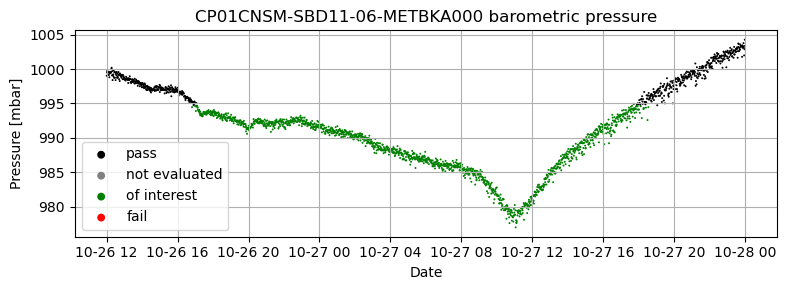

In [8]:
# Plot barometric pressure with new function
fig, ax = color_by_flag(cnsm_cyclone, "barometric_pressure")
plt.title(f"{refdes} barometric pressure")
plt.xlabel("Date")
plt.ylabel("Pressure [mbar]")
plt.show()

### Plot other METBK parameters during the same time period

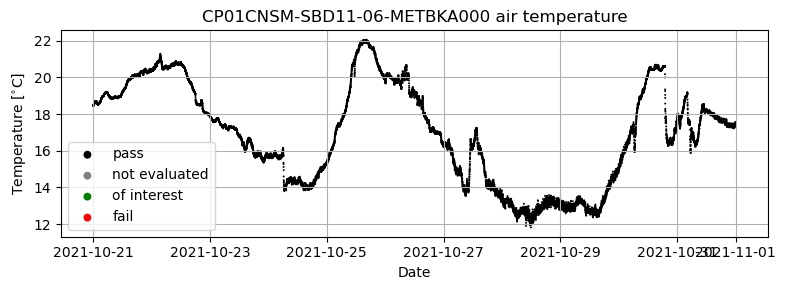

In [30]:
# Plot air temperature during bomb cyclone with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "air_temperature")
plt.title(f"{refdes} air temperature")
plt.xlabel("Date")
plt.ylabel("Air Temperature [$^{\circ}$C]")
plt.show()

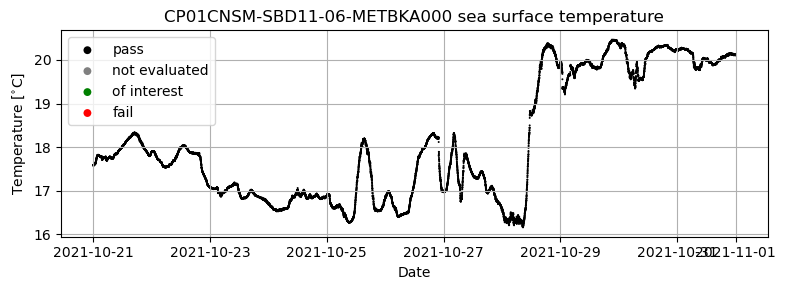

In [31]:
# Plot SST from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "sea_surface_temperature")
plt.title(f"{refdes} sea surface temperature")
plt.xlabel("Date")
plt.ylabel("Temperature [$^{\circ}$C]")
plt.show()

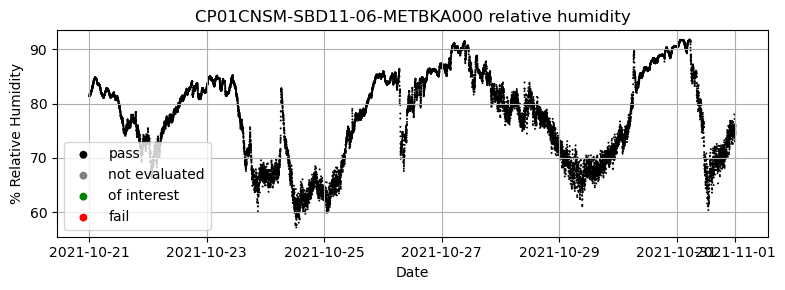

In [34]:
# Plot relative humidity from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "relative_humidity")
plt.title(f"{refdes} relative humidity")
plt.xlabel("Date")
plt.ylabel("% Relative Humidity")
ax.legend(loc="lower left", markerscale=4)
plt.show()

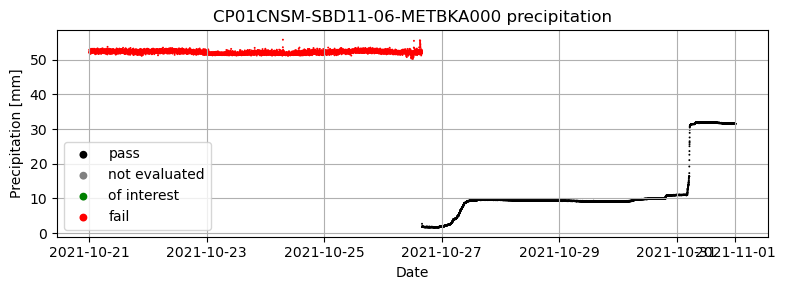

In [35]:
# Plot precipitation from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "precipitation")
plt.title(f"{refdes} precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation [mm]")
plt.show()

It is unclear just from looking at the above timeseries, but perhaps the precipitation sensor was saturated until the onset of the bomb cyclone.

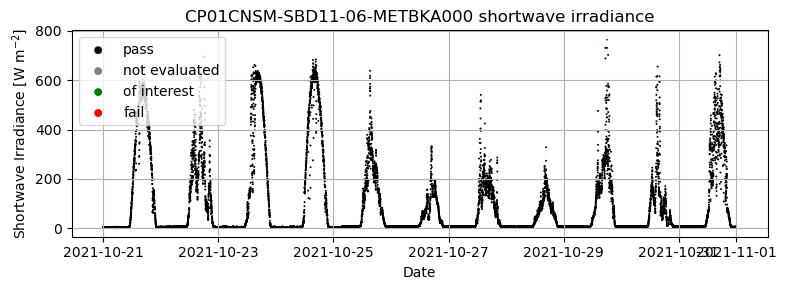

In [38]:
# Plot shortwave irradiance from deployment 14 with data point color from the QARTOD flag
fig, ax = color_by_flag(cnsm_metbk, "shortwave_irradiance")
plt.title(f"{refdes} shortwave irradiance")
plt.xlabel("Date")
plt.ylabel("Shortwave Irradiance [W m$^{-2}$]")
ax.legend(loc="upper left", markerscale=4)
plt.show()

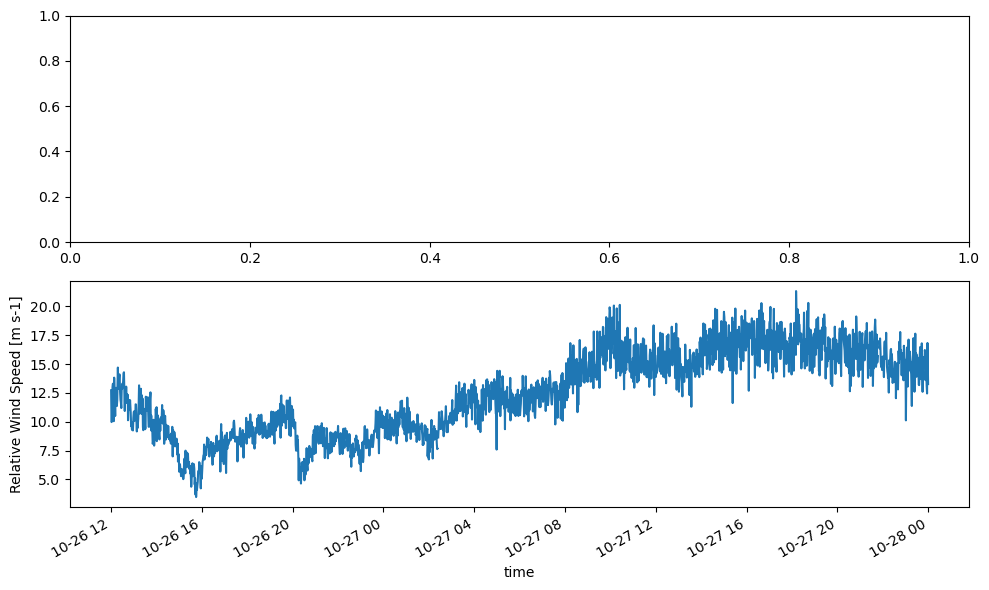

In [65]:
# Plot available wind variables in METBK dataset
fig, axs = plt.subplots(2, 1, figsize=(10, 6), layout="tight")
# cnsm_cyclone["met_wind10m"].plot.line(ax=axs[0])
cnsm_cyclone["met_relwind_speed"].plot.line(ax=axs[1])

### Compare CNSM barometric pressure to other surface moorings

In [7]:
# Set offshore surface mooring refdes and other data stream parameters
ossm_refdes = 'CP04OSSM-SBD11-06-METBKA000'
site, node, sensor = ossm_refdes.split('-',2)

In [ ]:
# Make asynchronous M2M request
ossm_data = m2m_request(site, node, sensor, method, stream)

In [ ]:
# Write asynchronous data request dict to a text file
with open(f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt", 'w') as text_file:
    text_file.write(str(ossm_data))

In [8]:
# Set inshore surface mooring refdes and other data stream parameters
issm_refdes = 'CP03ISSM-SBD11-06-METBKA000'
site, node, sensor = refdes.split('-',2)

In [44]:
# Make asynchronous M2M request
issm_data = m2m_request(site, node, sensor, method, stream)

Requesting:
	refdes: CP03ISSM-SBD11-06-METBKA000
	method: recovered_host
	stream: metbk_hourly
	from None to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 400/400 [20:04<00:00,  3.01s/it]


In [45]:
# Write asynchronous data request dict to a text file
with open(f"../data/external/{refdes}_{method}_{stream}_asyncm2m.txt", 'w') as text_file:
    text_file.write(str(issm_data))

In [9]:
# Import async data request dict from saved text files
file = f"../data/external/{ossm_refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    ossm_data = eval(f.read())

file = f"../data/external/{issm_refdes}_{method}_{stream}_asyncm2m.txt"
with open(file) as f:
    issm_data = eval(f.read())

In [10]:
# Load data from OSSM and ISSM from async requests
# ossm_metbk = m2m_collect(ossm_data, tag=('.*deployment%04d.*\.nc$' % deploy))
ossm_metbk = m2m_collect(ossm_data, tag=('.*deployment%03d.*metbk_a_dcl_instrument_recovered.*\.nc$' % 1))
issm_metbk = m2m_collect(issm_data, tag=('.*deployment%03d.*metbk_a_dcl_instrument_recovered.*\.nc$' % 1))

In [11]:
# Create subsets of datasets for the bomb cyclone and surrounding days
ossm_cyclone = ossm_metbk.sel(time=slice('2021-10-26T12:00:00','2021-10-28T00:00:00'))
issm_cyclone = issm_metbk.sel(time=slice('2021-10-26T12:00:00','2021-10-28T00:00:00'))

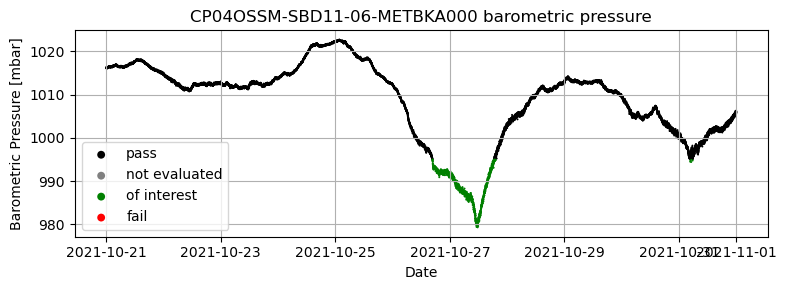

In [16]:
# Plot pressure during bomb cyclone from OSSM
fig, ax = color_by_flag(ossm_cyclone, "barometric_pressure")
plt.title("CP04OSSM-SBD11-06-METBKA000 barometric pressure")
plt.xlabel("Date")
plt.ylabel("Barometric Pressure [mbar]")
# ax.legend(loc="upper left", markerscale=4)
plt.show()

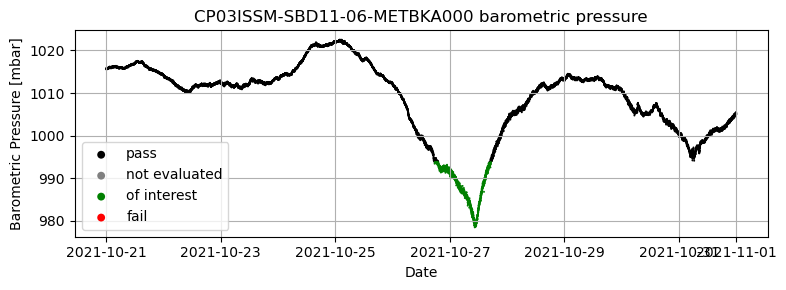

In [17]:
# Plot pressure during bomb cylone and surrounding days
fig, ax = color_by_flag(issm_cyclone, "barometric_pressure")
plt.title("CP03ISSM-SBD11-06-METBKA000 barometric pressure")
plt.xlabel("Date")
plt.ylabel("Barometric Pressure [mbar]")
# ax.legend(loc="upper left", markerscale=4)
plt.show()

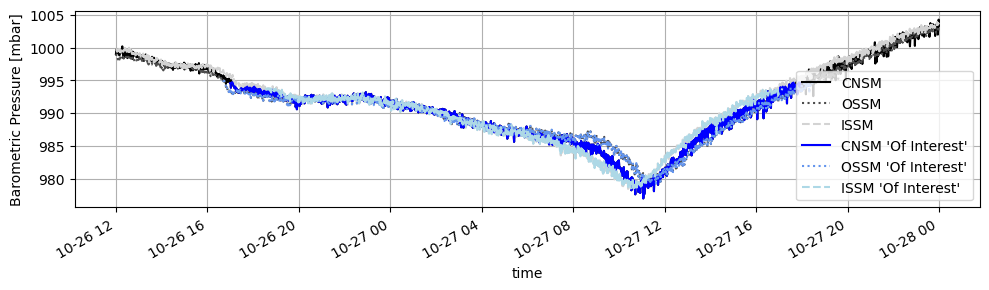

In [14]:
# Plot all 3 cyclone time series on same axes
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout="tight")
cnsm_cyclone["barometric_pressure"].plot.line(ax=ax, c="black", label="CNSM")
ossm_cyclone["barometric_pressure"].plot.line(ax=ax, c=[0.3, 0.3, 0.3], linestyle=":", label="OSSM")
issm_cyclone["barometric_pressure"].plot.line(ax=ax, c="lightgray", linestyle="--", label="ISSM")
cnsm_cyclone["barometric_pressure"].where(cnsm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=ax, c="blue", label="CNSM 'Of Interest'")
ossm_cyclone["barometric_pressure"].where(ossm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=ax, c="cornflowerblue", linestyle=":", label="OSSM 'Of Interest'")
issm_cyclone["barometric_pressure"].where(issm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=ax, c="lightblue", linestyle="--", label="ISSM 'Of Interest'")
plt.grid()
plt.legend()
plt.show()

### Create comparison figure with multiple locations and parameters

In [12]:
# Define start, end date of suspect flags and min values
start_int = cnsm_cyclone["time"].where(cnsm_cyclone["barometric_pressure_qartod_results"]==3, drop=True)[0].values
end_int = cnsm_cyclone["time"].where(cnsm_cyclone["barometric_pressure_qartod_results"]==3, drop=True)[-1].values
min_inshore = issm_cyclone["time"].where(
    issm_cyclone["barometric_pressure"]==issm_cyclone["barometric_pressure"].min(),
    drop=True)[0].values
min_offshore = ossm_cyclone["time"].where(
    ossm_cyclone["barometric_pressure"]==ossm_cyclone["barometric_pressure"].min(),
    drop=True)[0].values

/tmp/ipykernel_242/1425429436.py:39: UserWarning: The label '_not evaluated' of <matplotlib.collections.PathCollection object at 0x7f355d239c10> starts with '_'. It is thus excluded from the legend.
  axs[4].legend(["pass", "_not evaluated", "_of interest", "fail"], markerscale=4)
/tmp/ipykernel_242/1425429436.py:39: UserWarning: The label '_of interest' of <matplotlib.collections.PathCollection object at 0x7f355d222410> starts with '_'. It is thus excluded from the legend.
  axs[4].legend(["pass", "_not evaluated", "_of interest", "fail"], markerscale=4)


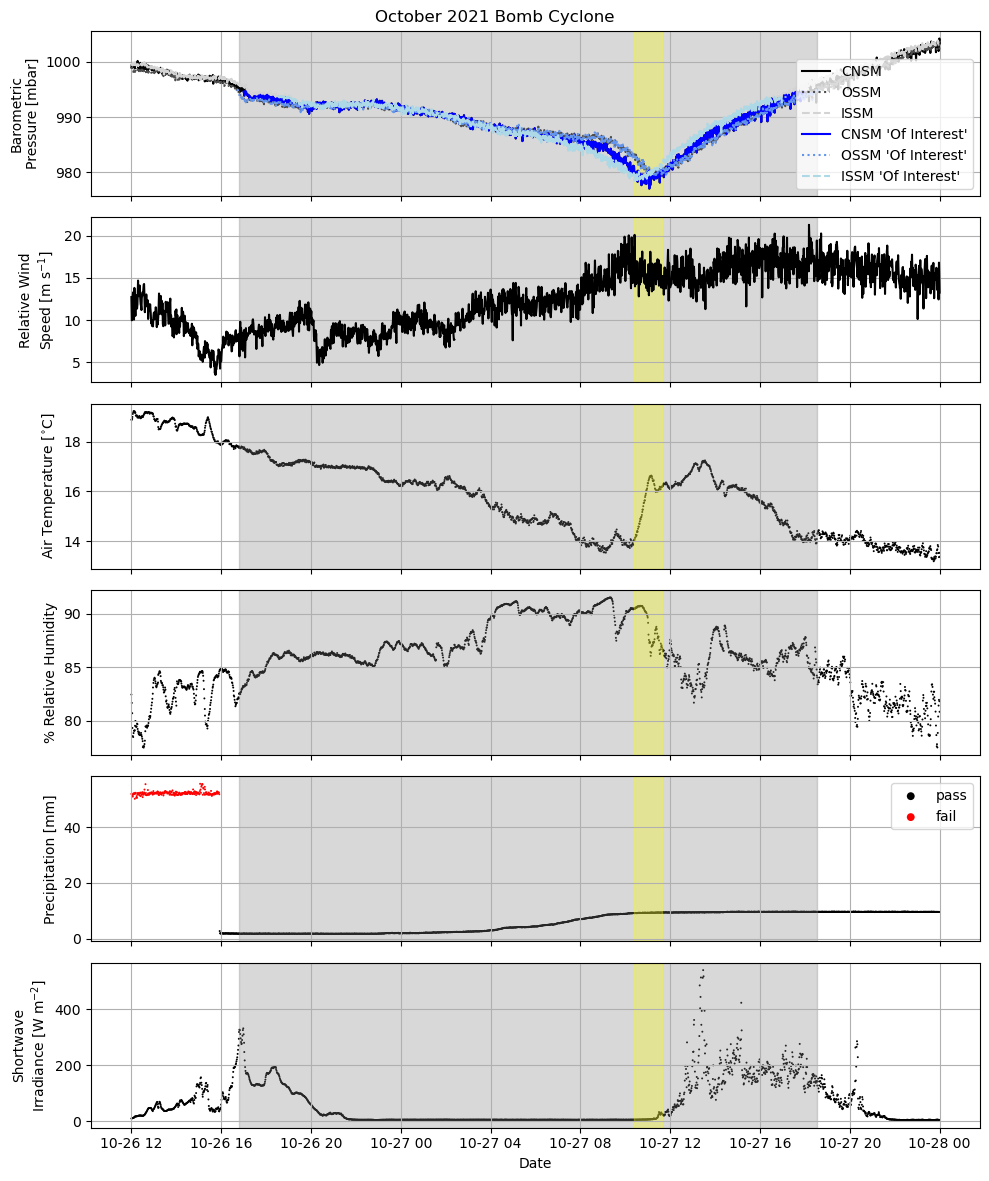

In [15]:
# Create figure of 4 other atmospheric parameters measured by METBK in subplots
fig, axs = plt.subplots(6, 1, figsize=(10,12), sharex=True, layout="tight")
cnsm_cyclone["barometric_pressure"].plot.line(ax=axs[0], c="black", label="CNSM")
ossm_cyclone["barometric_pressure"].plot.line(ax=axs[0], c=[0.3, 0.3, 0.3], linestyle=":", label="OSSM")
issm_cyclone["barometric_pressure"].plot.line(ax=axs[0], c="lightgray", linestyle="--", label="ISSM")
cnsm_cyclone["barometric_pressure"].where(cnsm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=axs[0], c="blue", label="CNSM 'Of Interest'")
ossm_cyclone["barometric_pressure"].where(ossm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=axs[0], c="cornflowerblue", linestyle=":", label="OSSM 'Of Interest'")
issm_cyclone["barometric_pressure"].where(issm_cyclone["barometric_pressure_qartod_results"]==3).plot.line(
    ax=axs[0], c="lightblue", linestyle="--", label="ISSM 'Of Interest'")
axs[0].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[0].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel("Barometric\nPressure [mbar]")
axs[0].set_xlabel("")
cnsm_cyclone["met_relwind_speed"].plot.line(ax=axs[1], color="black")
axs[1].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[1].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[1].set_ylabel("Relative Wind\nSpeed [m s$^{-1}$]")
axs[1].grid()
axs[1].set_xlabel("")
fig, ax = color_by_flag(cnsm_cyclone, "air_temperature", ax=axs[2], fig=fig)
ax.set_ylabel("Air Temperature [$^{\circ}$C]")
axs[2].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[2].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[2].grid()
fig, ax = color_by_flag(cnsm_cyclone, "relative_humidity", ax=axs[3], fig=fig)
ax.set_ylabel("% Relative Humidity")
axs[3].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[3].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[3].grid()
fig, ax = color_by_flag(cnsm_cyclone, "precipitation", ax=axs[4], fig=fig)
ax.set_ylabel("Precipitation [mm]")
axs[4].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[4].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[4].grid()
axs[4].legend(["pass", "_not evaluated", "_of interest", "fail"], markerscale=4)
fig, ax = color_by_flag(cnsm_cyclone, "shortwave_irradiance", ax=axs[5], fig=fig)
ax.set_xlabel("Date")
ax.set_ylabel("Shortwave\nIrradiance [W m$^{-2}$]")
axs[5].axvspan(start_int, end_int, color="gray", alpha=0.3)
axs[5].axvspan(min_inshore, min_offshore, color="yellow", alpha=0.3)
axs[5].grid()
plt.suptitle("October 2021 Bomb Cyclone")
plt.show()

In [16]:
# Save above figure as png in processed data
fig.savefig('../data/processed/2021_bomb_cyclone_comparison_{today}.png'.format(today=date.today().strftime('%Y%m%d')))

### Estimate wind speed from advection of atmospheric lows

Does approaching a question like this assume something about the spatial scale of atmospheric lows?